In [164]:
#import necessary library
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as dataloader
import torch.nn as nn



In [165]:
#transformation for plt to tensor
transformaion_operation=transforms.Compose([transforms.ToTensor()])



In [166]:
from torchvision.datasets.utils import download_and_extract_archive
train_dataset=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transformaion_operation)
val_dataset=torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=transformaion_operation)

In [167]:
#define variable
num_classes=10
batch_size=64
num_channels=1 # for others dataset num channel will be 3
image_size=28
patch_size=7
num_patches=(image_size//patch_size)**2 #integer value convert (w/p * (h/p)) square i hoy
print(num_patches)
#we are converting 1 patches into 1 vector
embedding_dim=64
attention_heads=4
transformer_block=4 # transformer block koyta erki mane encoder koyta.
learning_rate=0.001
epochs=5
mlp_hidden_nodes=128 # in gpt te embedding dimension *4 dey




16


In [168]:
#define bathes
train_loader=dataloader.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,)
val_loader=dataloader.DataLoader(val_dataset,batch_size=batch_size,shuffle=True,)


In [169]:
#Part -1 : patch embedding
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed=nn.Conv2d(num_channels,embedding_dim,kernel_size=patch_size,stride=patch_size)
  def forward(self,x):
    #patch embedding
    x=self.patch_embed(x)
    #flattering
    x=x.flatten(2) # keno 2 karon ami pathces gula ke 1 ta dimension e convert korbo . to patches index hocche 2 number e
    #ideally (64,16,64) 64 batches, 16 patches, 64 pathces dimension.  but we have (64,64,16) so we need to change it .
    x=x.transpose(1,2)
    return x





In [170]:
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1=nn.LayerNorm(embedding_dim)
    self.layer_norm2=nn.LayerNorm(embedding_dim)
    self.multihead_attention=nn.MultiheadAttention(embedding_dim,attention_heads,batch_first=True)
    self.mlp=nn.Sequential(
        nn.Linear(embedding_dim,mlp_hidden_nodes),
        nn.GELU(),
        nn.Linear(mlp_hidden_nodes, embedding_dim) # Corrected: output dimension should be embedding_dim

    )
  def forward(self,x):
    residual1=x
    x=self.layer_norm1(x)
    attn_output, _ =self.multihead_attention(x,x,x) # Fix: Correctly unpack both outputs, discard weights with _
    x=residual1+attn_output
    residual2=x
    x=self.layer_norm2(x)
    x=self.mlp(x)
    x=residual2+x
    return x

In [171]:
#part 3 MLP head
class MLP_head(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1=nn.LayerNorm(embedding_dim)
    self.mlp_head=nn.Linear(embedding_dim,num_classes)
  def forward(self,x):  # token gula paichi
    x=self.layer_norm1(x)
    x=self.mlp_head(x)
    return x

  #64 dimention theke 10 dimension e convert hoye geche .


In [172]:
class visionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding=PatchEmbedding()
    self.cls_token=nn.Parameter(torch.randn(1,1,embedding_dim)) #1 toaken 1 channel , 64 dimension
    self.positional_embedding=nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim))  # I need 1 CLS token that's the reason
    self.transformer_block=nn.Sequential(*[TransformerEncoder() for _ in range(transformer_block)])
    self.mlp_head=MLP_head()
  def forward(self,x):
    x=self.patch_embedding(x)
    B=x.shape[0] # amar kache ja ache tai pathabo 64 kore pathaile sesher index e 64 nao thakte pare.
    class_token=self.cls_token.expand(B,-1,-1)
    x=torch.cat((class_token,x),dim=1)
    x=x+self.positional_embedding
    x=self.transformer_block(x)
    x=x[:,0]
    x=self.mlp_head(x)
    return x

In [173]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=visionTransformer().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion=nn.CrossEntropyLoss()


In [174]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"\nEpoch {epoch + 1}")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accuracy
        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()
        correct_epoch += correct
        total_epoch += labels.size(0)
        total_loss += loss.item()

        if batch_idx % 100 == 0:
            accuracy = 100.0 * correct / labels.size(0)
            print(f"  Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = 100.0 * correct_epoch / total_epoch
    print(f"\n==> Epoch {epoch+1} Summary: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")

# ===============================
# End of Training
# ===============================


Epoch 1
  Batch   1: Loss = 2.4250, Accuracy = 10.94%
  Batch 101: Loss = 0.5218, Accuracy = 81.25%
  Batch 201: Loss = 0.2217, Accuracy = 95.31%
  Batch 301: Loss = 0.2231, Accuracy = 92.19%
  Batch 401: Loss = 0.2681, Accuracy = 92.19%
  Batch 501: Loss = 0.1788, Accuracy = 93.75%
  Batch 601: Loss = 0.2345, Accuracy = 90.62%
  Batch 701: Loss = 0.1512, Accuracy = 96.88%
  Batch 801: Loss = 0.1202, Accuracy = 96.88%
  Batch 901: Loss = 0.1249, Accuracy = 96.88%

==> Epoch 1 Summary: Loss = 0.3660, Accuracy = 88.45%

Epoch 2
  Batch   1: Loss = 0.2522, Accuracy = 95.31%
  Batch 101: Loss = 0.1141, Accuracy = 96.88%
  Batch 201: Loss = 0.1987, Accuracy = 93.75%
  Batch 301: Loss = 0.1129, Accuracy = 96.88%
  Batch 401: Loss = 0.0226, Accuracy = 100.00%
  Batch 501: Loss = 0.2287, Accuracy = 93.75%
  Batch 601: Loss = 0.1778, Accuracy = 96.88%
  Batch 701: Loss = 0.1513, Accuracy = 93.75%
  Batch 801: Loss = 0.0521, Accuracy = 98.44%
  Batch 901: Loss = 0.1824, Accuracy = 93.75%

==> E

In [175]:
# Switch to evaluation mode
model.eval()

# Disable gradient computation for inference
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = 100.0 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 97.73%


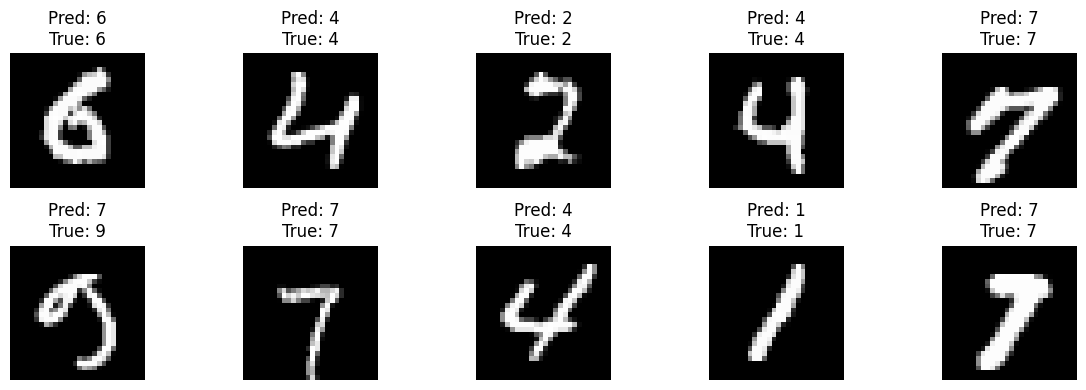

In [178]:
import matplotlib.pyplot as plt

# Show 10 predictions from the first test batch
model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Move to CPU for plotting
images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

# Plot first 10 images
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()